# Objective:
This notebook implements a Generative Adversarial Network (GAN) to generate
realistic human face images. The generator creates new images from random noise,
while the discriminator learns to distinguish between real and fake faces.

##Dataset: CelebA ( [CelebFaces Attributes](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)) Dataset

## Tasks Covered:
1. Preprocess face images (resize to 64x64 and normalize pixel values).
2. Implement GAN architecture (Generator + Discriminator using CNN layers).
3. Train the GAN using Binary Cross-Entropy loss.
4. Generate and visualize new face images after training.



---



# Setup and decompression from Drive

In [ ]:
# Setup and Unzip from Drive
import os, glob, zipfile
from pathlib import Path

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Path to your ZIP on Drive
ZIP_PATH = "/content/drive/MyDrive/Dataset/CelebA.zip"
EXTRACT_PATH = Path("/content/celeba_temp")

if not Path(ZIP_PATH).exists():
    raise FileNotFoundError(f"file not found {ZIP_PATH}")

# Unzip once to /content
EXTRACT_PATH.mkdir(parents=True, exist_ok=True)
print("Unzip from the drive", EXTRACT_PATH)
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_PATH)

# Locate images folder even if nested img_align_celeba/img_align_celeba
def find_img_dir(root: Path):
    for p in root.rglob("img_align_celeba"):
        if any((Path(p)).glob("*.jpg")):
            return p
    return None

imgs_dir = find_img_dir(EXTRACT_PATH)
if imgs_dir is None:
    raise RuntimeError("img_align_celeba was not found inside the source file.")
print("Photo file", imgs_dir)

Device: cuda
Mounted at /content/drive
Unzip from the drive /content/celeba_temp
Photo file /content/celeba_temp/img_align_celeba/img_align_celeba




---



# Data Loader

Converts images to 64x64 and values ​​[0,1]

In [ ]:
# Dataset and DataLoader
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.files = sorted(glob.glob(str(self.root_dir / "*.jpg")))
        if len(self.files) == 0:
            raise RuntimeError("There are no .jpg images inside the specified folder.")
        self.transform = transform or transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ConvertImageDtype(torch.float32), # Maintains [0,1]
        ])

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        img = torchvision.io.read_image(self.files[idx]).float() / 255.0
        if img.shape[0] == 1:  #Make sure its 3 channels
            img = img.repeat(3, 1, 1)
        img = self.transform(img)
        return img, 0

batch_size = 128 if torch.cuda.is_available() else 32
num_workers = 2 if torch.cuda.is_available() else 0

dataset = CelebADataset(imgs_dir)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                    num_workers=num_workers, pin_memory=torch.cuda.is_available(),
                    drop_last=True)

print("Number of images:", len(dataset), " | Batches per epoch:", len(loader))

Number of images: 202599  | Batches per epoch: 1582



---



# Models (Generator & Discriminator)

DCGAN with sigmaoid output [0,1]

In [ ]:
# Generator and Discriminator
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100, g_base=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, g_base*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(g_base*8), nn.ReLU(True),
            nn.ConvTranspose2d(g_base*8, g_base*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_base*4), nn.ReLU(True),
            nn.ConvTranspose2d(g_base*4, g_base*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_base*2), nn.ReLU(True),
            nn.ConvTranspose2d(g_base*2, g_base, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_base), nn.ReLU(True),
            nn.ConvTranspose2d(g_base, 3, 4, 2, 1, bias=False),
            nn.Sigmoid() #Output [0,1]
        )
    def forward(self, z): return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, d_base=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, d_base, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d_base, d_base*2, 4, 2, 1, bias=False), nn.BatchNorm2d(d_base*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d_base*2, d_base*4, 4, 2, 1, bias=False), nn.BatchNorm2d(d_base*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d_base*4, d_base*8, 4, 2, 1, bias=False), nn.BatchNorm2d(d_base*8), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d_base*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output probability
        )
    def forward(self, x): return self.net(x).view(-1)

# Preparing training models and details
z_dim = 100
G, D = Generator(z_dim).to(device), Discriminator().to(device)
optG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optD = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

from torchvision.utils import save_image
out_dir = Path("/content/gan_outputs")
(out_dir / "samples").mkdir(parents=True, exist_ok=True)
(out_dir / "ckpts").mkdir(parents=True, exist_ok=True)

epochs = 15
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)
G_losses, D_losses = [], []



---



# Training + Sample Savings + Checkpoints

Alternating updates, saving ckpt files and samples for each era

In [ ]:
# Training Loop (with checkpoints & samples)
import math
from tqdm.auto import tqdm

print("Start training . . . ")
for epoch in range(1, epochs+1):
    running_D, running_G = 0.0, 0.0

    # minimal change: wrap the loader with tqdm
    for i, (real_imgs, _) in enumerate(tqdm(loader, desc=f"Epoch {epoch}/{epochs}", dynamic_ncols=True), start=1):  # NEW
        real_imgs = real_imgs.to(device)
        bsz = real_imgs.size(0)
        real_labels = torch.ones(bsz, device=device)
        fake_labels = torch.zeros(bsz, device=device)

        # Train D
        optD.zero_grad()
        loss_real = criterion(D(real_imgs), real_labels)
        z = torch.randn(bsz, z_dim, 1, 1, device=device)
        fake = G(z).detach()
        loss_fake = criterion(D(fake), fake_labels)
        loss_D = loss_real + loss_fake
        loss_D.backward(); optD.step()

        # Train G
        optG.zero_grad()
        z = torch.randn(bsz, z_dim, 1, 1, device=device)
        gen = G(z)
        loss_G = criterion(D(gen), real_labels)
        loss_G.backward(); optG.step()

        G_losses.append(loss_G.item()); D_losses.append(loss_D.item())

        # brief live stats in the bar
        running_D += loss_D.item()
        running_G += loss_G.item()
        if i % 10 == 0:  # update the bar every 10 steps to keep it light
            avgD = running_D / i
            avgG = running_G / i
            tqdm.write(f"[Epoch {epoch}/{epochs}] step {i}/{len(loader)}  D={loss_D.item():.4f}  G={loss_G.item():.4f}  avgD={avgD:.4f}  avgG={avgG:.4f}")  # NEW

    # Preserving samples after each epoch
    with torch.no_grad():
        sample = G(fixed_noise).cpu()
    save_image(sample, str(out_dir / "samples" / f"epoch_{epoch:03d}.png"),
               nrow=int(math.sqrt(fixed_noise.size(0))))

    torch.save(
        {"G": G.state_dict(), "D": D.state_dict(),
         "optG": optG.state_dict(), "optD": optD.state_dict(),
         "epoch": epoch},
        str(out_dir / "ckpts" / f"ckpt_{epoch:03d}.pt")
    )

    print(f"Epoch {epoch}/{epochs} done")

Start training . . . 


Epoch 1/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 1/15] step 10/1582  D=0.1256  G=7.1767  avgD=0.3934  avgG=5.4078
[Epoch 1/15] step 20/1582  D=0.0498  G=7.4598  avgD=0.2245  avgG=6.4762
[Epoch 1/15] step 30/1582  D=0.0065  G=7.4795  avgD=0.1610  avgG=7.0852
[Epoch 1/15] step 40/1582  D=0.1026  G=7.3503  avgD=0.3745  avgG=7.6019
[Epoch 1/15] step 50/1582  D=0.6227  G=6.7017  avgD=0.4155  avgG=7.1992
[Epoch 1/15] step 60/1582  D=0.4400  G=4.9672  avgD=0.4629  avgG=6.7037
[Epoch 1/15] step 70/1582  D=0.8989  G=2.3873  avgD=0.5578  avgG=6.2001
[Epoch 1/15] step 80/1582  D=1.1420  G=0.9310  avgD=0.5905  avgG=5.7946
[Epoch 1/15] step 90/1582  D=1.0213  G=3.8846  avgD=0.6509  avgG=5.5302
[Epoch 1/15] step 100/1582  D=1.4327  G=2.6545  avgD=0.6793  avgG=5.3389
[Epoch 1/15] step 110/1582  D=1.2746  G=4.1545  avgD=0.7127  avgG=5.1459
[Epoch 1/15] step 120/1582  D=0.6935  G=2.8070  avgD=0.7374  avgG=4.9874
[Epoch 1/15] step 130/1582  D=0.9619  G=2.9125  avgD=0.7443  avgG=4.8405
[Epoch 1/15] step 140/1582  D=0.4854  G=3.1337  avgD=0.7581 

Epoch 2/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 2/15] step 10/1582  D=1.4908  G=0.8929  avgD=0.8362  avgG=2.8016
[Epoch 2/15] step 20/1582  D=0.8342  G=2.4408  avgD=0.8771  avgG=2.8622
[Epoch 2/15] step 30/1582  D=1.4038  G=1.1647  avgD=0.8550  avgG=2.7904
[Epoch 2/15] step 40/1582  D=0.7579  G=1.5273  avgD=0.8798  avgG=2.7251
[Epoch 2/15] step 50/1582  D=1.0594  G=1.7576  avgD=0.8589  avgG=2.6956
[Epoch 2/15] step 60/1582  D=0.6751  G=1.8437  avgD=0.8270  avgG=2.6403
[Epoch 2/15] step 70/1582  D=1.0040  G=1.9800  avgD=0.8673  avgG=2.6476
[Epoch 2/15] step 80/1582  D=0.6545  G=2.5483  avgD=0.8560  avgG=2.6268
[Epoch 2/15] step 90/1582  D=0.6839  G=2.0170  avgD=0.8374  avgG=2.6187
[Epoch 2/15] step 100/1582  D=0.5704  G=2.7361  avgD=0.8372  avgG=2.6386
[Epoch 2/15] step 110/1582  D=0.6953  G=2.6846  avgD=0.8283  avgG=2.6479
[Epoch 2/15] step 120/1582  D=0.8212  G=2.0960  avgD=0.8529  avgG=2.6571
[Epoch 2/15] step 130/1582  D=0.7209  G=3.3036  avgD=0.8454  avgG=2.6573
[Epoch 2/15] step 140/1582  D=0.5643  G=2.4749  avgD=0.8487 

Epoch 3/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 3/15] step 10/1582  D=0.5882  G=1.9854  avgD=0.7063  avgG=2.2225
[Epoch 3/15] step 20/1582  D=0.7400  G=3.4351  avgD=0.6775  avgG=2.3253
[Epoch 3/15] step 30/1582  D=0.6291  G=3.3394  avgD=0.6862  avgG=2.4047
[Epoch 3/15] step 40/1582  D=0.6131  G=3.0156  avgD=0.7273  avgG=2.4210
[Epoch 3/15] step 50/1582  D=0.4007  G=3.0760  avgD=0.7065  avgG=2.4453
[Epoch 3/15] step 60/1582  D=0.7837  G=0.8870  avgD=0.7111  avgG=2.4297
[Epoch 3/15] step 70/1582  D=0.6648  G=1.5551  avgD=0.6931  avgG=2.4172
[Epoch 3/15] step 80/1582  D=2.1103  G=0.2160  avgD=0.7205  avgG=2.4307
[Epoch 3/15] step 90/1582  D=0.8765  G=1.6333  avgD=0.7517  avgG=2.4138
[Epoch 3/15] step 100/1582  D=0.5614  G=1.8576  avgD=0.7419  avgG=2.4151
[Epoch 3/15] step 110/1582  D=0.6102  G=2.0399  avgD=0.7399  avgG=2.4240
[Epoch 3/15] step 120/1582  D=1.8805  G=0.7248  avgD=0.7538  avgG=2.4287
[Epoch 3/15] step 130/1582  D=0.8607  G=3.2037  avgD=0.7696  avgG=2.4356
[Epoch 3/15] step 140/1582  D=1.1306  G=1.3695  avgD=0.7701 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[Epoch 3/15] step 1070/1582  D=0.5549  G=2.0750  avgD=0.7385  avgG=2.4505
[Epoch 3/15] step 1080/1582  D=1.0332  G=3.8598  avgD=0.7394  avgG=2.4515
[Epoch 3/15] step 1090/1582  D=0.4567  G=2.1746  avgD=0.7385  avgG=2.4499
[Epoch 3/15] step 1100/1582  D=0.6238  G=2.2662  avgD=0.7391  avgG=2.4499
[Epoch 3/15] step 1110/1582  D=0.4767  G=3.0245  avgD=0.7372  avgG=2.4503
[Epoch 3/15] step 1120/1582  D=0.5281  G=1.8687  avgD=0.7364  avgG=2.4493
[Epoch 3/15] step 1130/1582  D=0.6819  G=1.4376  avgD=0.7360  avgG=2.4491
[Epoch 3/15] step 1140/1582  D=0.5241  G=1.7438  avgD=0.7343  avgG=2.4482
[Epoch 3/15] step 1150/1582  D=1.0244  G=4.2891  avgD=0.7346  avgG=2.4497
[Epoch 3/15] step 1160/1582  D=0.6956  G=1.4950  avgD=0.7358  avgG=2.4505
[Epoch 3/15] step 1170/1582  D=0.4150  G=1.4098  avgD=0.7345  avgG=2.4500
[Epoch 3/15] step 1180/1582  D=0.5958  G=3.0276  avgD=0.7350  avgG=2.4519


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[Epoch 3/15] step 1190/1582  D=0.6575  G=3.2815  avgD=0.7353  avgG=2.4533
[Epoch 3/15] step 1200/1582  D=0.4745  G=2.6362  avgD=0.7336  avgG=2.4527
[Epoch 3/15] step 1210/1582  D=1.2132  G=0.6281  avgD=0.7326  avgG=2.4531
[Epoch 3/15] step 1220/1582  D=1.0091  G=3.6175  avgD=0.7385  avgG=2.4561
[Epoch 3/15] step 1230/1582  D=0.7571  G=2.6643  avgD=0.7392  avgG=2.4572
[Epoch 3/15] step 1240/1582  D=0.7212  G=2.0228  avgD=0.7397  avgG=2.4588
[Epoch 3/15] step 1250/1582  D=0.5805  G=2.2041  avgD=0.7382  avgG=2.4584
[Epoch 3/15] step 1260/1582  D=0.5229  G=2.4922  avgD=0.7377  avgG=2.4577
[Epoch 3/15] step 1270/1582  D=0.6101  G=1.3860  avgD=0.7374  avgG=2.4574
[Epoch 3/15] step 1280/1582  D=0.4484  G=2.4584  avgD=0.7360  avgG=2.4573
[Epoch 3/15] step 1290/1582  D=0.4975  G=1.8284  avgD=0.7349  avgG=2.4564
[Epoch 3/15] step 1300/1582  D=1.9606  G=0.2132  avgD=0.7374  avgG=2.4567
[Epoch 3/15] step 1310/1582  D=0.8539  G=1.3544  avgD=0.7396  avgG=2.4556
[Epoch 3/15] step 1320/1582  D=0.5731 

Epoch 4/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 4/15] step 10/1582  D=0.3716  G=2.5011  avgD=0.5169  avgG=2.4885
[Epoch 4/15] step 20/1582  D=0.7477  G=3.7834  avgD=0.6497  avgG=2.5513
[Epoch 4/15] step 30/1582  D=0.4133  G=3.0054  avgD=0.6195  avgG=2.4718
[Epoch 4/15] step 40/1582  D=0.4198  G=2.8609  avgD=0.5850  avgG=2.4246
[Epoch 4/15] step 50/1582  D=0.4588  G=3.1648  avgD=0.6050  avgG=2.4599
[Epoch 4/15] step 60/1582  D=0.4159  G=2.7477  avgD=0.6001  avgG=2.4414
[Epoch 4/15] step 70/1582  D=0.5256  G=2.7077  avgD=0.5919  avgG=2.4262
[Epoch 4/15] step 80/1582  D=0.4693  G=2.1123  avgD=0.5826  avgG=2.4266
[Epoch 4/15] step 90/1582  D=0.4296  G=2.7230  avgD=0.5714  avgG=2.4394
[Epoch 4/15] step 100/1582  D=1.1546  G=3.6595  avgD=0.6384  avgG=2.4815
[Epoch 4/15] step 110/1582  D=0.7463  G=3.6132  avgD=0.6439  avgG=2.4733
[Epoch 4/15] step 120/1582  D=0.4645  G=2.5347  avgD=0.6595  avgG=2.4752
[Epoch 4/15] step 130/1582  D=0.3515  G=2.7285  avgD=0.6471  avgG=2.4766
[Epoch 4/15] step 140/1582  D=0.4673  G=3.3230  avgD=0.6403 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>self._shutdown_workers()

[Epoch 4/15] step 970/1582  D=0.6373  G=3.6982  avgD=0.6684  avgG=2.5378
[Epoch 4/15] step 980/1582  D=0.5025  G=3.0277  avgD=0.6688  avgG=2.5376
[Epoch 4/15] step 990/1582  D=0.3718  G=2.4810  avgD=0.6666  avgG=2.5371
[Epoch 4/15] step 1000/1582  D=0.4340  G=2.1544  avgD=0.6643  avgG=2.5366
[Epoch 4/15] step 1010/1582  D=0.8068  G=3.6540  avgD=0.6668  avgG=2.5390
[Epoch 4/15] step 1020/1582  D=0.7434  G=1.5228  avgD=0.6667  avgG=2.5385
[Epoch 4/15] step 1030/1582  D=0.8730  G=1.8254  avgD=0.6658  avgG=2.5398
[Epoch 4/15] step 1040/1582  D=0.6979  G=3.9872  avgD=0.6642  avgG=2.5392
[Epoch 4/15] step 1050/1582  D=0.3374  G=2.9089  avgD=0.6627  avgG=2.5375
[Epoch 4/15] step 1060/1582  D=0.3553  G=2.0371  avgD=0.6605  avgG=2.5363
[Epoch 4/15] step 1070/1582  D=0.6749  G=5.1319  avgD=0.6591  avgG=2.5392
[Epoch 4/15] step 1080/1582  D=0.5397  G=1.5475  avgD=0.6599  avgG=2.5400
[Epoch 4/15] step 1090/1582  D=0.6344  G=4.3024  avgD=0.6593  avgG=2.5422
[Epoch 4/15] step 1100/1582  D=1.2919  G=

Epoch 5/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 5/15] step 10/1582  D=1.1742  G=0.5262  avgD=0.6663  avgG=2.7327
[Epoch 5/15] step 20/1582  D=0.5873  G=1.4424  avgD=0.8522  avgG=2.7929
[Epoch 5/15] step 30/1582  D=1.2311  G=1.1610  avgD=0.8515  avgG=2.8065
[Epoch 5/15] step 40/1582  D=0.6144  G=1.7899  avgD=0.7959  avgG=2.8269
[Epoch 5/15] step 50/1582  D=0.4682  G=2.9072  avgD=0.7356  avgG=2.7913
[Epoch 5/15] step 60/1582  D=0.7175  G=3.1235  avgD=0.7439  avgG=2.7501
[Epoch 5/15] step 70/1582  D=0.4731  G=2.9540  avgD=0.7147  avgG=2.7307
[Epoch 5/15] step 80/1582  D=0.2901  G=2.9232  avgD=0.6834  avgG=2.7221
[Epoch 5/15] step 90/1582  D=0.3722  G=3.3114  avgD=0.6526  avgG=2.7037
[Epoch 5/15] step 100/1582  D=0.4160  G=3.2000  avgD=0.6420  avgG=2.7030
[Epoch 5/15] step 110/1582  D=0.3795  G=3.2902  avgD=0.6227  avgG=2.7007
[Epoch 5/15] step 120/1582  D=0.5552  G=3.1277  avgD=0.6632  avgG=2.7103
[Epoch 5/15] step 130/1582  D=0.4583  G=2.9628  avgD=0.6803  avgG=2.7146
[Epoch 5/15] step 140/1582  D=0.6108  G=1.6515  avgD=0.6668 

Exception ignored in: 

[Epoch 5/15] step 860/1582  D=0.5599  G=2.0457  avgD=0.6159  avgG=2.7046


<function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_worke

[Epoch 5/15] step 870/1582  D=0.5405  G=4.0386  avgD=0.6134  avgG=2.7052
[Epoch 5/15] step 880/1582  D=1.4993  G=4.2538  avgD=0.6194  avgG=2.7083
[Epoch 5/15] step 890/1582  D=0.7911  G=4.8051  avgD=0.6192  avgG=2.7075
[Epoch 5/15] step 900/1582  D=0.6036  G=1.2080  avgD=0.6179  avgG=2.7052
[Epoch 5/15] step 910/1582  D=0.5122  G=3.0478  avgD=0.6165  avgG=2.7067
[Epoch 5/15] step 920/1582  D=0.8811  G=4.5661  avgD=0.6196  avgG=2.7099
[Epoch 5/15] step 930/1582  D=0.4067  G=2.5100  avgD=0.6183  avgG=2.7069
[Epoch 5/15] step 940/1582  D=0.3743  G=2.4352  avgD=0.6160  avgG=2.7068
[Epoch 5/15] step 950/1582  D=0.4191  G=3.3146  avgD=0.6138  avgG=2.7079
[Epoch 5/15] step 960/1582  D=0.3688  G=2.7324  avgD=0.6122  avgG=2.7079
[Epoch 5/15] step 970/1582  D=0.7025  G=1.3603  avgD=0.6105  avgG=2.7093
[Epoch 5/15] step 980/1582  D=0.3117  G=2.2839  avgD=0.6094  avgG=2.7108
[Epoch 5/15] step 990/1582  D=0.3908  G=2.1733  avgD=0.6085  avgG=2.7106
[Epoch 5/15] step 1000/1582  D=0.4716  G=2.6933  av

Epoch 6/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 6/15] step 10/1582  D=0.3525  G=2.0375  avgD=0.5182  avgG=2.7774
[Epoch 6/15] step 20/1582  D=0.4276  G=2.0516  avgD=0.4656  avgG=2.7918
[Epoch 6/15] step 30/1582  D=0.4494  G=1.9878  avgD=0.4401  avgG=2.7944
[Epoch 6/15] step 40/1582  D=0.4991  G=3.3240  avgD=0.4765  avgG=2.8827
[Epoch 6/15] step 50/1582  D=0.2659  G=3.5400  avgD=0.4486  avgG=2.8855
[Epoch 6/15] step 60/1582  D=0.3104  G=3.4306  avgD=0.4321  avgG=2.8834
[Epoch 6/15] step 70/1582  D=1.6952  G=0.4067  avgD=0.4708  avgG=2.8881
[Epoch 6/15] step 80/1582  D=1.0000  G=5.2834  avgD=0.5280  avgG=2.9491
[Epoch 6/15] step 90/1582  D=0.6631  G=1.2784  avgD=0.5346  avgG=2.9307
[Epoch 6/15] step 100/1582  D=0.8703  G=1.8166  avgD=0.5367  avgG=2.9382
[Epoch 6/15] step 110/1582  D=0.2786  G=2.7981  avgD=0.5254  avgG=2.9352
[Epoch 6/15] step 120/1582  D=0.4133  G=2.0797  avgD=0.5125  avgG=2.9210
[Epoch 6/15] step 130/1582  D=0.3085  G=3.7171  avgD=0.4967  avgG=2.9304
[Epoch 6/15] step 140/1582  D=0.5265  G=1.6142  avgD=0.5231 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360

[Epoch 6/15] step 770/1582  D=0.7667  G=1.0045  avgD=0.5380  avgG=2.9398
[Epoch 6/15] step 780/1582  D=0.3561  G=2.3977  avgD=0.5393  avgG=2.9394
[Epoch 6/15] step 790/1582  D=0.4557  G=2.2765  avgD=0.5379  avgG=2.9374
[Epoch 6/15] step 800/1582  D=0.3030  G=2.4347  avgD=0.5360  avgG=2.9367
[Epoch 6/15] step 810/1582  D=0.5690  G=1.4609  avgD=0.5344  avgG=2.9361
[Epoch 6/15] step 820/1582  D=0.5119  G=2.1729  avgD=0.5327  avgG=2.9366
[Epoch 6/15] step 830/1582  D=0.3146  G=2.0941  avgD=0.5300  avgG=2.9363
[Epoch 6/15] step 840/1582  D=0.3542  G=4.2396  avgD=0.5276  avgG=2.9379
[Epoch 6/15] step 850/1582  D=0.3476  G=3.5107  avgD=0.5255  avgG=2.9378
[Epoch 6/15] step 860/1582  D=0.2863  G=3.5372  avgD=0.5227  avgG=2.9358
[Epoch 6/15] step 870/1582  D=0.1871  G=2.8843  avgD=0.5194  avgG=2.9381
[Epoch 6/15] step 880/1582  D=0.2326  G=2.9475  avgD=0.5160  avgG=2.9390
[Epoch 6/15] step 890/1582  D=0.3192  G=4.7933  avgD=0.5131  avgG=2.9420
[Epoch 6/15] step 900/1582  D=0.3886  G=0.9910  avg

Epoch 7/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 7/15] step 10/1582  D=0.8188  G=6.4111  avgD=0.4067  avgG=3.6121
[Epoch 7/15] step 20/1582  D=0.8048  G=2.8133  avgD=1.1868  avgG=3.3530
[Epoch 7/15] step 30/1582  D=0.4667  G=3.3176  avgD=0.9912  avgG=3.1442
[Epoch 7/15] step 40/1582  D=0.4178  G=3.7129  avgD=0.8434  avgG=3.1021
[Epoch 7/15] step 50/1582  D=0.3498  G=2.0243  avgD=0.7521  avgG=3.0792
[Epoch 7/15] step 60/1582  D=0.2693  G=2.7732  avgD=0.6801  avgG=3.0648
[Epoch 7/15] step 70/1582  D=0.6934  G=5.7667  avgD=0.6298  avgG=3.0963
[Epoch 7/15] step 80/1582  D=1.2295  G=6.1322  avgD=0.7242  avgG=3.0997
[Epoch 7/15] step 90/1582  D=0.4696  G=2.6098  avgD=0.7219  avgG=3.0673
[Epoch 7/15] step 100/1582  D=0.7083  G=5.1206  avgD=0.6970  avgG=3.0733
[Epoch 7/15] step 110/1582  D=0.3569  G=2.3180  avgD=0.6701  avgG=3.0554
[Epoch 7/15] step 120/1582  D=0.2929  G=2.8750  avgD=0.6429  avgG=3.0588
[Epoch 7/15] step 130/1582  D=0.3362  G=2.4944  avgD=0.6298  avgG=3.0625
[Epoch 7/15] step 140/1582  D=0.3420  G=1.8644  avgD=0.6061 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: Exception ignored in: can only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 7/15] step 670/1582  D=0.5381  G=3.7495  avgD=0.5075  avgG=3.0367
[Epoch 7/15] step 680/1582  D=0.5508  G=5.5015  avgD=0.5088  avgG=3.0400
[Epoch 7/15] step 690/1582  D=0.3187  G=3.4557  avgD=0.5090  avgG=3.0427
[Epoch 7/15] step 700/1582  D=0.3168  G=2.2513  avgD=0.5061  avgG=3.0414
[Epoch 7/15] step 710/1582  D=1.1122  G=1.7547  avgD=0.5054  avgG=3.0439
[Epoch 7/15] step 720/1582  D=0.3224  G=2.9584  avgD=0.5038  avgG=3.0478
[Epoch 7/15] step 730/1582  D=0.2821  G=3.9600  avgD=0.5019  avgG=3.0505
[Epoch 7/15] step 740/1582  D=0.2717  G=3.6898  avgD=0.4990  avgG=3.0516
[Epoch 7/15] step 750/1582  D=0.3678  G=3.9863  avgD=0.4960  avgG=3.0532
[Epoch 7/15] step 760/1582  D=0.2859  G=2.4345  avgD=0.4938  avgG=3.0540
[Epoch 7/15] step 770/1582  D=0.4285  G=0.9510  avgD=0.4999  avgG=3.0575
[Epoch 7/15] step 780/1582  D=1.1226  G=6.7635  avgD=0.5045  avgG=3.0636
[Epoch 7/15] step 790/1582  D=0.3167  G=4.3118  avgD=0.5044  avgG=3.0662
[Epoch 7/15] step 800/1582  D=0.7757  G=2.6805  avg

Epoch 8/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 8/15] step 10/1582  D=0.4150  G=4.1936  avgD=0.3594  avgG=3.0592
[Epoch 8/15] step 20/1582  D=0.3642  G=4.2918  avgD=0.3107  avgG=3.0637
[Epoch 8/15] step 30/1582  D=0.6603  G=5.0710  avgD=0.3170  avgG=3.1092
[Epoch 8/15] step 40/1582  D=0.2899  G=2.3247  avgD=0.3350  avgG=3.0482
[Epoch 8/15] step 50/1582  D=0.2201  G=3.7319  avgD=0.3193  avgG=3.0777
[Epoch 8/15] step 60/1582  D=0.1767  G=3.0397  avgD=0.2986  avgG=3.0944
[Epoch 8/15] step 70/1582  D=0.2301  G=2.4184  avgD=0.2935  avgG=3.1130
[Epoch 8/15] step 80/1582  D=2.0769  G=1.1951  avgD=0.3197  avgG=3.1078
[Epoch 8/15] step 90/1582  D=0.3118  G=3.2412  avgD=0.3357  avgG=3.1053
[Epoch 8/15] step 100/1582  D=0.2290  G=3.1487  avgD=0.3279  avgG=3.1072
[Epoch 8/15] step 110/1582  D=0.2977  G=2.1929  avgD=0.3191  avgG=3.1157
[Epoch 8/15] step 120/1582  D=0.4784  G=3.4884  avgD=0.3314  avgG=3.1383
[Epoch 8/15] step 130/1582  D=0.1582  G=3.5936  avgD=0.3277  avgG=3.1518
[Epoch 8/15] step 140/1582  D=0.1461  G=3.9023  avgD=0.3211 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^^    ^^^self._shutdown_workers()^^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    ^if w.is_alive():



[Epoch 8/15] step 440/1582  D=0.2631  G=2.9990  avgD=0.4267  avgG=3.1772
[Epoch 8/15] step 450/1582  D=0.2889  G=2.8055  avgD=0.4234  avgG=3.1806
[Epoch 8/15] step 460/1582  D=0.2203  G=3.9208  avgD=0.4185  avgG=3.1811
[Epoch 8/15] step 470/1582  D=0.2135  G=3.2102  avgD=0.4155  avgG=3.1836
[Epoch 8/15] step 480/1582  D=0.2609  G=1.5650  avgD=0.4112  avgG=3.1811
[Epoch 8/15] step 490/1582  D=0.1547  G=2.7020  avgD=0.4076  avgG=3.1849
[Epoch 8/15] step 500/1582  D=0.3380  G=1.7347  avgD=0.4035  avgG=3.1847
[Epoch 8/15] step 510/1582  D=0.1569  G=3.6774  avgD=0.4005  avgG=3.1921
[Epoch 8/15] step 520/1582  D=1.3747  G=0.7247  avgD=0.4370  avgG=3.1976
[Epoch 8/15] step 530/1582  D=0.5567  G=3.2207  avgD=0.4508  avgG=3.1871
[Epoch 8/15] step 540/1582  D=0.4677  G=3.1859  avgD=0.4527  avgG=3.1838
[Epoch 8/15] step 550/1582  D=0.4497  G=1.7645  avgD=0.4560  avgG=3.1835
[Epoch 8/15] step 560/1582  D=0.1710  G=3.4996  avgD=0.4551  avgG=3.1842
[Epoch 8/15] step 570/1582  D=0.5063  G=5.8461  avg

Epoch 9/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 9/15] step 10/1582  D=0.1570  G=3.6977  avgD=0.1848  avgG=3.4258
[Epoch 9/15] step 20/1582  D=0.1302  G=3.0530  avgD=0.1762  avgG=3.3606
[Epoch 9/15] step 30/1582  D=0.1280  G=3.5572  avgD=0.1651  avgG=3.4163
[Epoch 9/15] step 40/1582  D=0.0994  G=3.4526  avgD=0.1582  avgG=3.4585
[Epoch 9/15] step 50/1582  D=0.1268  G=4.5564  avgD=0.1624  avgG=3.4867
[Epoch 9/15] step 60/1582  D=0.1871  G=2.6075  avgD=0.1683  avgG=3.4587
[Epoch 9/15] step 70/1582  D=1.6949  G=0.8102  avgD=0.4177  avgG=3.4617
[Epoch 9/15] step 80/1582  D=0.2811  G=2.8491  avgD=0.4589  avgG=3.3875
[Epoch 9/15] step 90/1582  D=0.3226  G=2.3194  avgD=0.4561  avgG=3.3567
[Epoch 9/15] step 100/1582  D=2.6424  G=7.1973  avgD=0.4733  avgG=3.3619
[Epoch 9/15] step 110/1582  D=0.5349  G=2.1045  avgD=0.4994  avgG=3.3003
[Epoch 9/15] step 120/1582  D=0.1875  G=2.9173  avgD=0.4968  avgG=3.2817
[Epoch 9/15] step 130/1582  D=0.3560  G=1.4094  avgD=0.4810  avgG=3.2756
[Epoch 9/15] step 140/1582  D=0.2331  G=4.1841  avgD=0.4713 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/d

[Epoch 9/15] step 340/1582  D=0.2767  G=5.0168  avgD=0.3528  avgG=3.3621
[Epoch 9/15] step 350/1582  D=1.8479  G=4.5245  avgD=0.3840  avgG=3.3659
[Epoch 9/15] step 360/1582  D=0.6496  G=1.3482  avgD=0.3971  avgG=3.3574
[Epoch 9/15] step 370/1582  D=0.2471  G=2.4803  avgD=0.4004  avgG=3.3528
[Epoch 9/15] step 380/1582  D=0.3259  G=3.4836  avgD=0.3993  avgG=3.3548
[Epoch 9/15] step 390/1582  D=0.2300  G=2.4135  avgD=0.3944  avgG=3.3497
[Epoch 9/15] step 400/1582  D=0.2413  G=2.6645  avgD=0.3900  avgG=3.3482
[Epoch 9/15] step 410/1582  D=0.2246  G=2.5760  avgD=0.3895  avgG=3.3513
[Epoch 9/15] step 420/1582  D=0.1704  G=3.7745  avgD=0.3869  avgG=3.3564
[Epoch 9/15] step 430/1582  D=0.1928  G=2.7539  avgD=0.3826  avgG=3.3574
[Epoch 9/15] step 440/1582  D=0.1754  G=3.1627  avgD=0.3789  avgG=3.3608
[Epoch 9/15] step 450/1582  D=0.1637  G=4.2276  avgD=0.3741  avgG=3.3665
[Epoch 9/15] step 460/1582  D=0.1034  G=3.4798  avgD=0.3695  avgG=3.3653
[Epoch 9/15] step 470/1582  D=0.2631  G=2.8814  avg

Epoch 10/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 10/15] step 10/1582  D=0.2726  G=3.6195  avgD=0.3527  avgG=3.4398
[Epoch 10/15] step 20/1582  D=0.2079  G=3.0293  avgD=0.2856  avgG=3.3753
[Epoch 10/15] step 30/1582  D=0.3360  G=2.5238  avgD=0.2712  avgG=3.4252
[Epoch 10/15] step 40/1582  D=0.2268  G=2.2910  avgD=0.2567  avgG=3.4151
[Epoch 10/15] step 50/1582  D=0.2024  G=2.9382  avgD=0.2449  avgG=3.4246
[Epoch 10/15] step 60/1582  D=0.1610  G=3.5600  avgD=0.2406  avgG=3.4040
[Epoch 10/15] step 70/1582  D=0.2753  G=5.3923  avgD=0.2318  avgG=3.4263
[Epoch 10/15] step 80/1582  D=0.1918  G=3.0123  avgD=0.2260  avgG=3.4553
[Epoch 10/15] step 90/1582  D=0.1745  G=3.9893  avgD=0.2172  avgG=3.4690
[Epoch 10/15] step 100/1582  D=0.3209  G=4.8378  avgD=0.2191  avgG=3.4736
[Epoch 10/15] step 110/1582  D=0.2081  G=2.8028  avgD=0.2166  avgG=3.4823
[Epoch 10/15] step 120/1582  D=0.1575  G=2.9142  avgD=0.2096  avgG=3.4939
[Epoch 10/15] step 130/1582  D=0.1437  G=4.0008  avgD=0.2075  avgG=3.5034
[Epoch 10/15] step 140/1582  D=0.1399  G=3.4769

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>    
Traceback (most recent 

[Epoch 10/15] step 240/1582  D=0.3185  G=1.8551  avgD=0.3386  avgG=3.4506
[Epoch 10/15] step 250/1582  D=0.2600  G=3.0968  avgD=0.3371  avgG=3.4540
[Epoch 10/15] step 260/1582  D=0.2627  G=4.5921  avgD=0.3321  avgG=3.4579
[Epoch 10/15] step 270/1582  D=0.1506  G=3.0787  avgD=0.3262  avgG=3.4553
[Epoch 10/15] step 280/1582  D=0.2801  G=4.3026  avgD=0.3341  avgG=3.4634
[Epoch 10/15] step 290/1582  D=0.2770  G=3.8666  avgD=0.3395  avgG=3.4650
[Epoch 10/15] step 300/1582  D=0.4453  G=1.1196  avgD=0.3361  avgG=3.4581
[Epoch 10/15] step 310/1582  D=0.2436  G=2.8734  avgD=0.3422  avgG=3.4655
[Epoch 10/15] step 320/1582  D=0.2692  G=4.1469  avgD=0.3384  avgG=3.4720
[Epoch 10/15] step 330/1582  D=0.2759  G=4.1149  avgD=0.3390  avgG=3.4795
[Epoch 10/15] step 340/1582  D=0.1988  G=3.2499  avgD=0.3359  avgG=3.4805
[Epoch 10/15] step 350/1582  D=0.1628  G=3.1469  avgD=0.3325  avgG=3.4856
[Epoch 10/15] step 360/1582  D=0.1121  G=2.8857  avgD=0.3329  avgG=3.4871
[Epoch 10/15] step 370/1582  D=0.1482 

Epoch 11/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 11/15] step 10/1582  D=0.0797  G=4.2361  avgD=0.0980  avgG=3.6891
[Epoch 11/15] step 20/1582  D=0.1240  G=4.5068  avgD=0.1105  avgG=3.6797
[Epoch 11/15] step 30/1582  D=0.2085  G=3.1608  avgD=0.1167  avgG=3.7220
[Epoch 11/15] step 40/1582  D=0.1821  G=3.0273  avgD=0.1162  avgG=3.7808
[Epoch 11/15] step 50/1582  D=0.0878  G=4.5254  avgD=0.1142  avgG=3.8138
[Epoch 11/15] step 60/1582  D=1.6353  G=5.6239  avgD=0.1897  avgG=3.8369
[Epoch 11/15] step 70/1582  D=0.7356  G=2.8241  avgD=0.3659  avgG=3.7840
[Epoch 11/15] step 80/1582  D=0.2342  G=2.5167  avgD=0.3629  avgG=3.7238
[Epoch 11/15] step 90/1582  D=0.5198  G=1.5551  avgD=0.3500  avgG=3.6774
[Epoch 11/15] step 100/1582  D=0.2881  G=3.6036  avgD=0.3894  avgG=3.6820
[Epoch 11/15] step 110/1582  D=0.2020  G=3.9168  avgD=0.3937  avgG=3.6716
[Epoch 11/15] step 120/1582  D=0.1204  G=4.0602  avgD=0.3802  avgG=3.6675


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 11/15] step 130/1582  D=0.1322  G=3.7315  avgD=0.3647  avgG=3.6581
[Epoch 11/15] step 140/1582  D=0.1487  G=4.0037  avgD=0.3531  avgG=3.6622
[Epoch 11/15] step 150/1582  D=0.2380  G=3.3224  avgD=0.3424  avgG=3.6662
[Epoch 11/15] step 160/1582  D=0.3320  G=6.0194  avgD=0.3312  avgG=3.6764
[Epoch 11/15] step 170/1582  D=0.1116  G=4.2442  avgD=0.3239  avgG=3.6790
[Epoch 11/15] step 180/1582  D=0.3294  G=1.0768  avgD=0.3151  avgG=3.6675
[Epoch 11/15] step 190/1582  D=0.2107  G=3.5901  avgD=0.3355  avgG=3.6683
[Epoch 11/15] step 200/1582  D=0.1634  G=3.9383  avgD=0.3293  avgG=3.6621
[Epoch 11/15] step 210/1582  D=0.1515  G=3.1422  avgD=0.3217  avgG=3.6624
[Epoch 11/15] step 220/1582  D=0.1342  G=3.1829  avgD=0.3134  avgG=3.6741
[Epoch 11/15] step 230/1582  D=0.7879  G=3.2064  avgD=0.3909  avgG=3.6809
[Epoch 11/15] step 240/1582  D=0.5747  G=3.3696  avgD=0.4113  avgG=3.6524
[Epoch 11/15] step 250/1582  D=0.2354  G=3.6171  avgD=0.4090  avgG=3.6377
[Epoch 11/15] step 260/1582  D=0.5632 

Epoch 12/15:   0%|          | 0/1582 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 12/15] step 10/1582  D=0.1683  G=4.1742  avgD=0.2510  avgG=3.7464
[Epoch 12/15] step 20/1582  D=0.1110  G=4.3376  avgD=0.2305  avgG=3.8333
[Epoch 12/15] step 30/1582  D=0.1145  G=3.5989  avgD=0.1997  avgG=3.7240
[Epoch 12/15] step 40/1582  D=0.1547  G=2.4054  avgD=0.1922  avgG=3.7584
[Epoch 12/15] step 50/1582  D=0.1350  G=3.7317  avgD=0.1825  avgG=3.7868
[Epoch 12/15] step 60/1582  D=0.1833  G=2.2099  avgD=0.1797  avgG=3.7830
[Epoch 12/15] step 70/1582  D=0.1468  G=3.5779  avgD=0.1736  avgG=3.8075
[Epoch 12/15] step 80/1582  D=0.0776  G=3.7958  avgD=0.1652  avgG=3.8530
[Epoch 12/15] step 90/1582  D=0.0782  G=4.2824  avgD=0.1619  avgG=3.8766
[Epoch 12/15] step 100/1582  D=0.2668  G=6.7502  avgD=0.1573  avgG=3.9061
[Epoch 12/15] step 110/1582  D=0.1342  G=3.5599  avgD=0.1685  avgG=3.8672
[Epoch 12/15] step 120/1582  D=0.2300  G=4.6776  avgD=0.1667  avgG=3.8795
[Epoch 12/15] step 130/1582  D=0.0913  G=4.2779  avgD=0.1615  avgG=3.8817
[Epoch 12/15] step 140/1582  D=0.0997  G=3.1028

Epoch 13/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 13/15] step 10/1582  D=1.6308  G=0.6162  avgD=2.1214  avgG=2.4367
[Epoch 13/15] step 20/1582  D=2.1413  G=0.9150  avgD=1.5476  avgG=2.7295
[Epoch 13/15] step 30/1582  D=0.4950  G=2.4234  avgD=1.2005  avgG=2.8451
[Epoch 13/15] step 40/1582  D=0.4944  G=6.2482  avgD=0.9811  avgG=2.9942
[Epoch 13/15] step 50/1582  D=0.2922  G=2.3551  avgD=0.8740  avgG=3.0406
[Epoch 13/15] step 60/1582  D=0.3083  G=1.5003  avgD=0.7776  avgG=3.1104
[Epoch 13/15] step 70/1582  D=0.2113  G=3.1947  avgD=0.7502  avgG=3.1870
[Epoch 13/15] step 80/1582  D=0.1781  G=3.2435  avgD=0.6816  avgG=3.2051
[Epoch 13/15] step 90/1582  D=0.2643  G=3.2099  avgD=0.6628  avgG=3.2383
[Epoch 13/15] step 100/1582  D=0.1871  G=3.3728  avgD=0.6157  avgG=3.2845
[Epoch 13/15] step 110/1582  D=0.1648  G=4.4792  avgD=0.5768  avgG=3.3339
[Epoch 13/15] step 120/1582  D=0.1909  G=4.4676  avgD=0.5393  avgG=3.3705
[Epoch 13/15] step 130/1582  D=1.3701  G=4.3513  avgD=0.5588  avgG=3.3879
[Epoch 13/15] step 140/1582  D=0.5280  G=2.1542

Epoch 14/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 14/15] step 10/1582  D=0.0815  G=3.8919  avgD=0.1074  avgG=4.3121
[Epoch 14/15] step 20/1582  D=0.1155  G=3.8222  avgD=0.0954  avgG=4.2956
[Epoch 14/15] step 30/1582  D=0.0565  G=3.4891  avgD=0.0921  avgG=4.2317
[Epoch 14/15] step 40/1582  D=0.1494  G=5.5644  avgD=0.0918  avgG=4.2623
[Epoch 14/15] step 50/1582  D=1.3126  G=6.2635  avgD=0.3463  avgG=4.1852
[Epoch 14/15] step 60/1582  D=1.0174  G=1.5344  avgD=0.3875  avgG=4.0618
[Epoch 14/15] step 70/1582  D=0.3042  G=2.1694  avgD=0.3743  avgG=4.0140
[Epoch 14/15] step 80/1582  D=0.1456  G=3.3545  avgD=0.3506  avgG=4.0195
[Epoch 14/15] step 90/1582  D=0.0890  G=4.0568  avgD=0.3358  avgG=4.0322
[Epoch 14/15] step 100/1582  D=0.1143  G=4.8043  avgD=0.3139  avgG=4.0275
[Epoch 14/15] step 110/1582  D=0.5299  G=2.3081  avgD=0.3948  avgG=3.9617
[Epoch 14/15] step 120/1582  D=0.3114  G=5.7994  avgD=0.3881  avgG=3.9415
[Epoch 14/15] step 130/1582  D=0.1181  G=3.0675  avgD=0.3823  avgG=3.9453
[Epoch 14/15] step 140/1582  D=0.0818  G=3.6930

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
       Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360> 
  Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    ^^^if w.is_alive():^^
^^ ^ ^ ^ ^ ^^  ^^^

[Epoch 14/15] step 1250/1582  D=0.1000  G=3.4052  avgD=0.2784  avgG=4.0759
[Epoch 14/15] step 1260/1582  D=0.1004  G=4.5878  avgD=0.2771  avgG=4.0768
[Epoch 14/15] step 1270/1582  D=0.1227  G=3.2482  avgD=0.2757  avgG=4.0784
[Epoch 14/15] step 1280/1582  D=0.0789  G=3.6091  avgD=0.2742  avgG=4.0812
[Epoch 14/15] step 1290/1582  D=0.0631  G=4.0542  avgD=0.2727  avgG=4.0819
[Epoch 14/15] step 1300/1582  D=0.0834  G=2.8706  avgD=0.2713  avgG=4.0824
[Epoch 14/15] step 1310/1582  D=0.0727  G=4.7948  avgD=0.2711  avgG=4.0858
[Epoch 14/15] step 1320/1582  D=0.0895  G=4.6692  avgD=0.2696  avgG=4.0860
[Epoch 14/15] step 1330/1582  D=0.1312  G=6.3211  avgD=0.2682  avgG=4.0893
[Epoch 14/15] step 1340/1582  D=0.0827  G=4.0664  avgD=0.2669  avgG=4.0914
[Epoch 14/15] step 1350/1582  D=0.0754  G=5.1973  avgD=0.2654  avgG=4.0946
[Epoch 14/15] step 1360/1582  D=0.0801  G=5.3804  avgD=0.2640  avgG=4.0967
[Epoch 14/15] step 1370/1582  D=0.0482  G=4.7729  avgD=0.2625  avgG=4.0991
[Epoch 14/15] step 1380/1

Epoch 15/15:   0%|          | 0/1582 [00:00<?, ?it/s]

[Epoch 15/15] step 10/1582  D=0.0568  G=4.8679  avgD=0.0950  avgG=4.3877
[Epoch 15/15] step 20/1582  D=0.0653  G=4.8311  avgD=0.1109  avgG=4.4731
[Epoch 15/15] step 30/1582  D=0.0434  G=5.2695  avgD=0.0954  avgG=4.5674
[Epoch 15/15] step 40/1582  D=0.0544  G=4.0521  avgD=0.0852  avgG=4.5030
[Epoch 15/15] step 50/1582  D=0.0624  G=4.0541  avgD=0.0818  avgG=4.5117
[Epoch 15/15] step 60/1582  D=1.6267  G=0.9664  avgD=0.3696  avgG=4.4059
[Epoch 15/15] step 70/1582  D=0.2379  G=1.9908  avgD=0.4061  avgG=4.2562
[Epoch 15/15] step 80/1582  D=0.1262  G=4.2983  avgD=0.3919  avgG=4.2056
[Epoch 15/15] step 90/1582  D=0.1114  G=3.9615  avgD=0.3653  avgG=4.1988
[Epoch 15/15] step 100/1582  D=0.1192  G=3.9855  avgD=0.3413  avgG=4.1849
[Epoch 15/15] step 110/1582  D=0.1175  G=3.7266  avgD=0.3361  avgG=4.1620
[Epoch 15/15] step 120/1582  D=2.7557  G=0.2915  avgD=0.3699  avgG=4.1472
[Epoch 15/15] step 130/1582  D=0.3950  G=2.6030  avgD=0.3926  avgG=4.1214
[Epoch 15/15] step 140/1582  D=0.2797  G=3.2798

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7df2ccc24360>
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^^^

AssertionError  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
:     c

[Epoch 15/15] step 1150/1582  D=0.0594  G=4.9154  avgD=0.2983  avgG=4.0547
[Epoch 15/15] step 1160/1582  D=0.1186  G=5.5552  avgD=0.2963  avgG=4.0596
[Epoch 15/15] step 1170/1582  D=0.1045  G=5.0102  avgD=0.2947  avgG=4.0613
[Epoch 15/15] step 1180/1582  D=0.0495  G=4.8088  avgD=0.2928  avgG=4.0671
[Epoch 15/15] step 1190/1582  D=0.0571  G=4.0952  avgD=0.2908  avgG=4.0721
[Epoch 15/15] step 1200/1582  D=0.0358  G=5.0975  avgD=0.2888  avgG=4.0760
[Epoch 15/15] step 1210/1582  D=0.1454  G=2.6828  avgD=0.2870  avgG=4.0785
[Epoch 15/15] step 1220/1582  D=0.0616  G=4.4322  avgD=0.2852  avgG=4.0826
[Epoch 15/15] step 1230/1582  D=0.0308  G=4.6093  avgD=0.2832  avgG=4.0872
[Epoch 15/15] step 1240/1582  D=0.0870  G=5.0919  avgD=0.2815  avgG=4.0913
[Epoch 15/15] step 1250/1582  D=0.0667  G=5.0645  avgD=0.2797  avgG=4.0944
[Epoch 15/15] step 1260/1582  D=2.5294  G=5.1734  avgD=0.2941  avgG=4.0949
[Epoch 15/15] step 1270/1582  D=0.6496  G=4.4819  avgD=0.2981  avgG=4.0853
[Epoch 15/15] step 1280/1



---



# Loss curve + visual comparison (real vs. generated)

Visual evaluation

save inside /content/gan_outputs
 - loss_curves.png
 - samples/epoch_XXX.png
 - samples/compare_final.png
 - ckpts/ckpt_XXX.pt


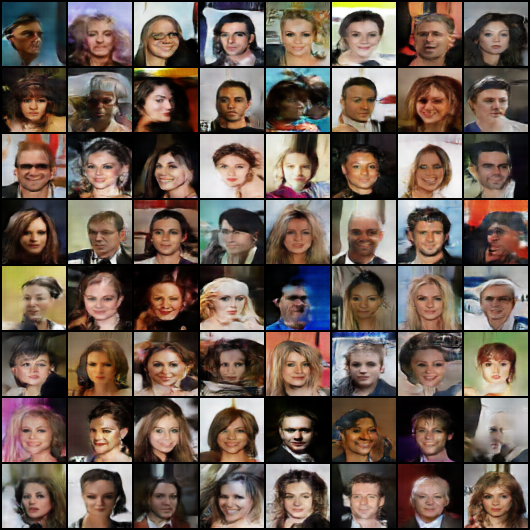

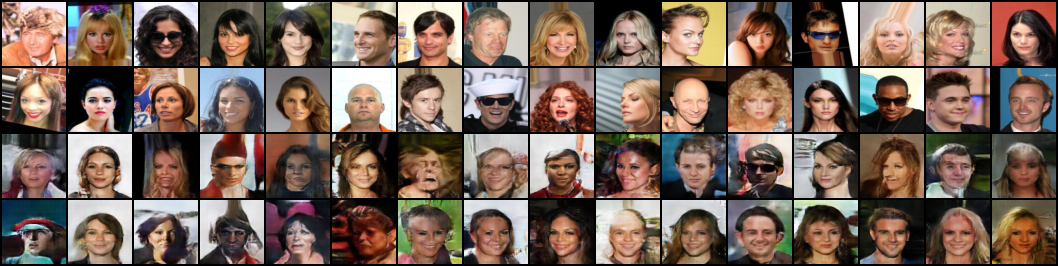

In [ ]:
#Curves + Visual Comparison
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Loss Curve
plt.figure()
plt.plot(D_losses, label="D"); plt.plot(G_losses, label="G")
plt.legend(); plt.title("GAN Training Loss"); plt.tight_layout()
plt.savefig(str(out_dir / "loss_curves.png")); plt.close()

#Real samples against a generator
real_batch, _ = next(iter(loader))
n = min(32, real_batch.size(0), 64)
with torch.no_grad():
    fake_batch = G(torch.randn(n, z_dim, 1, 1, device=device)).cpu()

comp = torch.cat([real_batch[:n].cpu(), fake_batch[:n]], dim=0)
save_image(comp, str(out_dir / "samples" / "compare_final.png"), nrow=max(1, n//2))

print("save inside", out_dir)
print(" - loss_curves.png")
print(" - samples/epoch_XXX.png")
print(" - samples/compare_final.png")
print(" - ckpts/ckpt_XXX.pt")

# Show example
from IPython.display import Image, display
display(Image(filename=str(out_dir / "samples" / f"epoch_{epochs:03d}.png")))
display(Image(filename=str(out_dir / "samples" / "compare_final.png")))



---



# Analysis results

### **GAN Results Analysis (CelebA Dataset)**

**Experiment Description:**  
A DCGAN model was trained on the elebA dataset, which contains over 200,000 human face images.  
The experiment was executed in Google Colab (T4 GPU) for 15 epochs.  
The goal was to teach the generator to learn the statistical distribution of real faces in order to create new, realistic ones from random noise.

---

### **Loss Curve Analysis**  
- The **Discriminator (D)** loss gradually decreased and stabilized around 0.3, indicating that it learned effectively without overpowering the generator.  
- The **Generator (G)** loss fluctuated between 3 – 5, which is expected and shows a healthy adversarial balance between both networks.  
- No signs of mode collapse appeared, as the generator continued producing diverse samples.

---

### **Image Quality Evolution**  
- **Early epochs (1–3):** The generated images were blurry and noisy, as the generator was still learning basic facial structures.  
- **Middle epochs (7–10):** Facial features started to appear — eyes, hair, and skin tones became more coherent.  
- **Final epochs (15):** The model produced mostly realistic faces with consistent shapes and lighting.  

---

### **General Conclusion**  
The DCGAN successfully **learned the facial data distribution** and was able to generate new, realistic-looking faces.  
Both generator and discriminator losses remained stable, confirming balanced adversarial training.  

---

### **Suggestions for Future Improvement**  
- Increase the training epochs to 30–50 for higher visual detail.  
- Normalize the dataset to [-1, +1] instead of dividing by 255 to improve stability.  
- Try more advanced architectures such as WGAN-GP or StyleGAN for enhanced realism and stability.